# Tarea5

**Envío del PR inicial:** lunes 17 de octubre

**Aceptación del PR:** lunes 31 de octubre

In [8]:
using Plots, LsqFit, Roots,Polynomials
include("AutomDiff_V2.jl")
import AD: Dual, xdual
using TaylorSeries
using LaTeXStrings

pyplot(grid=:false, legend=:false, size=(400,267))

Plots.PyPlotBackend()

**Ejercicio 1:**

Obtengan, para la familia de mapeos cuadrática $Q_c(x)$, el exponente de Lyapunov en términos de $c$.



Ya que el exponente de Liaponov se obtiene como 
\begin{equation}
\lambda(x_0) = \lim_{n\to\infty} \frac{1}{n} \sum_{i=1}^n \log
\Big| \, f'(x_i)\, \Big|.
\end{equation}
Con $x_i$ la iteración $i$ del punto $x_0$ bajo $f$, $x_i=f^i(x_0)$


Por lo tanto, primero creamos la función  'interado' que guarda las iteraciones de una función.

In [9]:
doc"""
    iterado(F,x0,n)

Dado un punto $x_0$, esta funció guarda a todas la iteraciones bajo $F$ en un arreglo.
"""

function iterado(F::Function,x0::Float64,n::Int)
    y = [x0] ##El primer elemento es x_0
    x = x0
    for i in 1:n
        x=F(x) #El valor de x cambia con cada iteración
        push!(y,x) #Este nuevo valor se guarda en el arreglo
    end
    y
end

iterado

Nuestra función de iteración es $Q_c = x^2 +c$

In [10]:
Qc(x,c)=x^2+c 

Qc (generic function with 1 method)

En seguida calculamos la suma que define al exponente.

In [11]:
doc"""
    Liaponov(y, F)

Dado un punto un arreglo que contenga todas las iteraciones bajo $F$ de $x_0$, calcula $\frac{1}{n} \sum_{i=1}^n \log
\Big| \, f'(x_i)\, \Big|.$
"""

function Liaponov(y, F::Function)
    n = length(y)
    l = 0
   
    for i in 1:n
        x = abs((F(xdual(y[i]))).der)
        l = l + log(x)
       
    end
    l/n
end

Liaponov

Ya que tenemos el exponente de Liaponov para un punto, calculamos el exponente para diferentes valores de $c$ de nuestra función $Q_c$.

In [39]:
doc"""
    mapeo_liap_all(crange,Qc,x0,n)

Calcula el exponente de Liaponov para un rango de valores de $c$ para $Q_c = x^2 +c$
"""

function mapeo_liap_all(crange,Qc::Function,x0::Float64,n::Int)
    map=Float64[]
  
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Liaponov(y, Qci)
      
       
        if abs(l)<Inf #En algunos puntos labda diverge, por lo que si tiende a infinito, se la asigna el valor-2.5
           push!(map,l)      
          else
           push!(map,-2.5)       
          end
      
    end
    map
end

mapeo_liap_all

Calculamos los exponentes para todo el rango en el que previamente habíamos hecho el mapeo de $Q_c$. 

$c \in [-2,0]$

In [40]:
crange = 0.25:-1/2^10:-2
map= mapeo_liap_all(crange,Qc,1.0,10000);


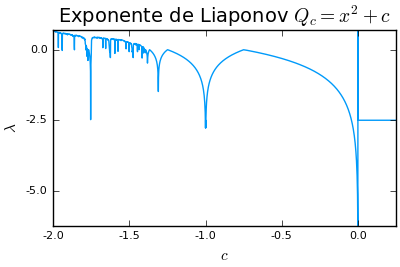

In [38]:
p = plot(crange,map)

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Liaponov $Q_c = x^2 +c$")

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) para los valores
de $c$ donde hay bifurcaciones?

Marcamos los puntos conocodos donde hay bifucaciones: $c = -0.75,-1.25$


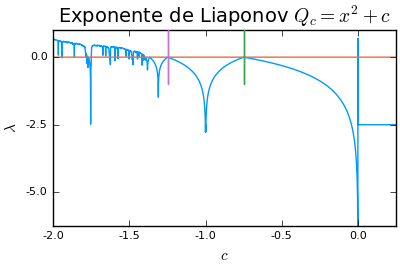

In [37]:
p = plot(crange,map)
plot!(crange, x->0)
plot!([-0.75,  -0.75], [1, -1, 1])
plot!([-1.25,  -1.25], [1, -1, 1])

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Liaponov $Q_c = x^2 +c$")

Vemos que en los puntos de bifurcación, $\lambda = 0$. Además, mientras se presenten  bifurcaciones $0 \geq \lambda$. 

Así que podemos graficar hasta el punto en el que dejen de haber bifurcaciones al dejar de guardar lambdas cuando cambia de signo.

In [51]:
doc"""
    mapeo_liap_all(crange,Qc,x0,n)

Calcula el exponente de Liaponov($\lambda$) para un rango de valores de 
$c$ para $Q_c = x^2+c$ mientras $0 \geq \lambda$
"""

function mapeo_liap(crange,Qc::Function,x0::Float64,n::Int)
    map=Float64[]
    cmap = Float64[]
    for i in crange
        Qci(x) = Qc(x,i) 
        y = iterado(Qci,x0,n)
        l = Liaponov(y, Qci)
        if l <= 0   #Mientras lambda sea menor o igual que 0, guarda el exponente
           if abs(l)<Inf
            push!(map,l)      
           else
            push!(map,-2.5)       
           end
        else
            break  #Cuando cambia de signo se detiene
        end
    end
    
    for i in 1:length(map)
        push!(cmap,crange[i])
    end
    map,cmap
end

mapeo_liap

In [44]:
crange = -(0.75-1/2^16):-1/2^16:-1.405
map,c = mapeo_liap(crange,Qc,1.0,10000);


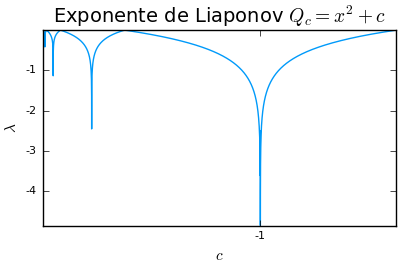

In [46]:
p = plot(c,map)
xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Liaponov $Q_c = x^2 +c$")

- ¿Qué particularidad ocurre (en términos del exponente de Lyapunov) cuando tenemos *ciclos superestables*, es decir, cuando $x=0$ es parte de un ciclo periódico?

Al igual que con las bifurcaciones, marcamos los puntos conocidos donde hay puntos superestables. $c= -1,-1.3107 $


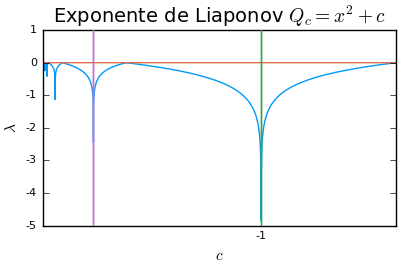

In [50]:
p = plot(crange,map)
plot!(crange, x->0)
plot!([-1,  -1], [1, -5, 1])
plot!([-1.3107 ,  -1.3107 ], [1, -5, 1])

xlabel!(L"c")
ylabel!(L"\lambda")
title!(L"Exponente de Liaponov $Q_c = x^2 +c$")

Vemos que $\lambda$ diverge en los puntos super estables del mapeo.

**Ejercicio 2:**

Rehacer los cálculos de los exponentes de Feigenbaum,
\begin{eqnarray*}
f_n &=& \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}},\\
a_n &=& \frac{d_n}{d_{n+1}},
\end{eqnarray*}

usando los valores $C_n$ donde se tienen ciclos superestables de periodo $2^n$. (Este ejercicio es muy parecido a los ejercicios 1 y 3 de la `Tarea4`.)

En la última gráfica obtenida, nos interesa obtener los puntos de divergencia, los cuales en este caso son los máximos del valor absoluto de $\lambda$. Así que creamos una función que filtre los máximos.

In [53]:
doc"""
    maxs(map,crange)

Para un mapeo dado y su respectivo rango, filtra los valores del rango para los cuales el mapeo tiene un 
máximo en su valor absoluto.
"""

function maxs(map,crange)
    n = length(map)
    c = Float64[]
    for i in 2:n-1
        if (abs(map[i+1]) < abs(map[i]) > abs(map[i-1])) #Condición para un punto máximo
            push!(c,(crange[i])) #guarda el punto del rango en el cual ocurre el máximo
        end
    end
    c
end

maxs

In [55]:
cs1 = (maxs(map,c))
cs1=deleteat!(cs1,1) #Nos dimos cuenta que el primer y el quinto lugar son valores repetidos,
cs1=deleteat!(cs1,5) #por lo cual son eliminados

7-element Array{Float64,1}:
 -1.00002
 -1.3107 
 -1.38155
 -1.39694
 -1.40025
 -1.40096
 -1.40111

In [56]:
doc"""
    newton1D(f, adiv, tol = 1e-10)

Realiza el método de Newton para una función $f$ dada una adivinanza 'adiv' 
con una tolerancia de '1e-10' o a la 1000-ésima iteración
"""

function newton1D{T<:Real}(f::Function, adiv::T, tol = 1e-10)
    x0 = xdual(adiv)
    fx = f(x0)
    count = 0
    while abs(fx.fun) > tol
        count += 1
        it = x0.fun - fx.fun/fx.der
        x0 = xdual(it)
        fx = f(x0)
        if count == 1000
            break
        end
    end
    return x0.fun
end

Qc(x,c) = x^2 + c

doc"""
    Qcⁿ(x, args)

Esta función define el n-enésimo iterado de $Qc(x,c)$,
donde el valor a iterar es `x` y el valor del parámetro
es `c`, donde `c = args[1]` y `n = args[2]`.
"""
function Qcⁿ(x, args)
    c, n = args[1], args[2]
    @assert n >= 0 && isa(n,Int)
    n <= 1 && return Qc(x,c)
    for it = 1:n
        x = Qc(x,c)
    end
    return x
end

Qcⁿ

Utilizando en método de Newton, obtenemos el punto superestable para una $Q_c^n$ de periodo $2^n$

In [59]:
doc"""
    superestables(cs)

Un conjunto de puntos presumiblemente superestables es perfeccionado utilizando método de Newton.
Para el arreglo ordenado de menor a mayor, cada valor corresponde al periodo de orden $2^n$
"""

function superestables(cs)
    
    for i in 1:length(cs)
        Q4c = c -> Qcⁿ(0.0, (c, 2^i)) #Se toma el polinomio de periodo adecuado
        C2 = newton1D(Q4c, cs[i]) #Se aplica el método de Newton
        cs[i]=C2 #Se sutituye el valor anterior por el nuevo valor mejorado
    end
    cs
end

superestables

In [60]:
cs1 = superestables(cs1)


7-element Array{Float64,1}:
 -1.0    
 -1.3107 
 -1.38155
 -1.39695
 -1.40025
 -1.40096
 -1.40111

In [63]:
doc"""
feigen(cs)

Para los elementos de un arreglo, calcula:
$f_n &=& \frac{C_n-C_{n+1}}{C_{n+1}-C_{n+2}}$
"""
function feigen(cs)
    f = Float64[]
    for i in 3:length(cs)
        fei=((cs[i-2])-(cs[i-1]))/((cs[i-1])-(cs[i]))
        push!(f,fei)
        end
    f
end


feigen

In [64]:
feigen(cs1)

5-element Array{Float64,1}:
 4.38568
 4.60095
 4.65513
 4.66611
 4.66855

Obtenemos $f=4.66855$, comparado con el valor real de $f=4.66920$

Los valores de d, para la segunda constante de Feigenbaum son lo valores más pequeños de la órbita, distintos de 0. De esta forma, para los puntos superestables obtenidos, calculamos toda su órbita, y selesccionamos el valor absoluto mínimo, descartando el 0.

In [65]:
doc"""
DS(cs1)

Para un arreglo de puntos super estables, obtiene el iterado de la longitud de su órbita y selecciona el valor de 
menor valor absoluto.
"""
function DS(cs1)
    dn = Float64[]
    for i in 1: length(cs1)
        d = minabs(deleteat!((iterado(x -> Qc(x,cs1[i]),0.0,2^(i-1))),1))
        push!(dn,d)
    end
    dn
end

doc"""
cociente(ds)

Para un arreglo de $d's$ calcula el cociente $a_n &=& \frac{d_n}{d_{n+1}}$
"""

function cociente(ds)
    f = Float64[]
    for i in 2:length(ds)
        fei=(ds[i-1]/ds[i])
        push!(f,fei)
        end
    f
end

cociente

In [66]:
ds = DS(cs1)

7-element Array{Float64,1}:
 1.0       
 0.407239  
 0.163425  
 0.0653634 
 0.0261213 
 0.0104369 
 0.00416997

In [67]:
cociente(ds)

6-element Array{Float64,1}:
 2.45556
 2.49189
 2.50026
 2.50231
 2.50277
 2.50288

Obtenemos $a=2.50288$ , comparado con el valor real de $a=2.50291$.

**Ejercicio 3:**

Comparar gráficamente los mapeos $Q_{c}(x)$ y $Q_{c^\prime}^2(x)$ para $c=1/4, 0, -3/4, -1, -2, -2.2$ y $c^\prime=-3/4,-1,-5/4,-1.3, -1.546\dots, -1.65$. 



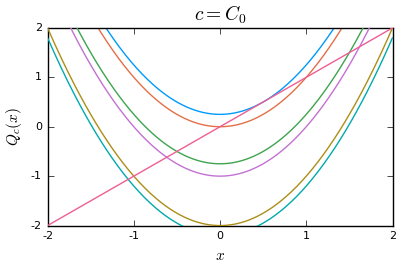

In [373]:
cplot1 = [0,-0.75,-1,-2,-2.2]
xrange = -2:1/64:2
plot(xrange, x->Qcⁿ(x, (0.25,1)))
for i in cplot1
    plot!(xrange, x->Qcⁿ(x, (i,1)))
end
plot!(xrange, x->x)
ylims!(-2,2)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"c = C_0")


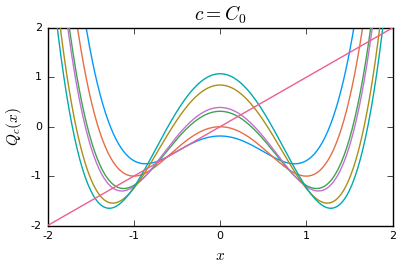

In [374]:
cplot2 = [-1,-1.25,-1.3,-1.546,-1.65]
xrange = -2:1/64:2
plot(xrange, x->Qcⁿ(x, (-0.75,2)))
for i in cplot2
    plot!(xrange, x->Qcⁿ(x, (i,2)))
end
plot!(xrange, x->x)
ylims!(-2,2)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"c = C_0")


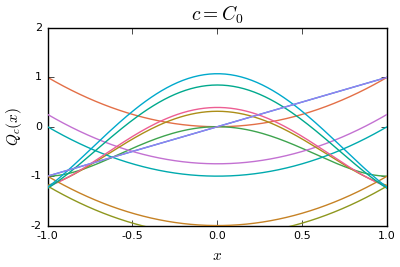

In [375]:

xrange = -1:1/64:1

plot(xrange, x->x)
#plot(xrange, x->Qcⁿ(x, (0.25,1)))
#plot!(xrange, x->Qcⁿ(x, (-0.75,2)))
for i in 1:5
    plot!(xrange, x->Qcⁿ(x, (cplot1[i],1)))
    plot!(xrange, x->Qcⁿ(x, (cplot2[i],2)))
end


plot!(xrange, x->x)
ylims!(-2,2)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"c = C_0")

In [380]:
"""
    ciclosestables!(xx, f, nit, nout, cc)

Esta función itera el mapeo `f`, de una variable, `nit+nout` veces, 
usando como condición inicial `x0=0`; los últimos `nout` iterados 
actualizan al vector `xx` que tiene longitud `nout`. `cc` es el valor
del parámetro del mapeo `f`. El mapeo `f` debe ser definido de 
tal manera que `f(x0,cc)` tenga sentido. La idea es los últimos 
`nout` iterados reflejen los ciclos estables del mapeo `f`. 
"""
function ciclosestables!(xx, f, nit, nout, cc)
    @assert nit > 0 && nout > 0
    
    # Primeros nit iterados
    x0 = 0.0
    for it = 1:nit
        x0 = f(x0, cc)
    end
    
    # Se guardan los siguientes nout iterados
    for it = 1:nout
        x0 = f(x0, cc)
        @inbounds xx[it] = x0
    end
    
    nothing
end

ciclosestables!

In [381]:
"""
    diagbifurc(f, nit, nout, crange)

Itera el mapeo `f` `nit+nout` veces y regresa una matriz
cuya columna `i` tiene los últimos `nout` iterados del mapeo
para el valor del parámetro del mapeo `crange[i]`.

La función `f` debe ser definida de tal manera que `f(x0, c)` 
tenga sentido.
"""
function diagbifurc(f, nit, nout, crange)
    xx = Vector{Float64}(nout)
    ff = Array{Float64,2}(nout, length(crange))
    
    for ic in eachindex(crange)
        c = crange[ic]
        ciclosestables!(xx, f, nit, nout, c)
        ff[:,ic] = xx
    end
    
    return ff
end

diagbifurc

**Ejercicio 4:**

Estudiar la dinámica para $c=-2.2$

- ¿Cómo se caracteriza el valor al que tiende *casi* cualquier condición inicial en el
intervalo $I=[-p_+,p_+]$ (donde $p_+$ es el valor positivo tal que $Q_c(p_+)=p_+$), después de muchos iterados? (El intervalo $I$ es donde "toda la dinámica interesante ocurre".)

- ¿Qué condición se requiere, en términos de $I$ (y de los iterados de $Q_c(x)$, para que se cumpla el inciso anterior?

- Caracterizen al complemento del conjunto de los casos anteriores, es decir, cuando los iterados de la condición inicial **no** llegan a donde *casi* cualquier condición inicial termina. ¿Cómo se conoce a este conjunto?

**Ejercicio 5:**

- Usando el análisis gráfico para un valor de $c$ *ligeramente* anterior al punto donde se observa la ventana de periodo 3 para la familia $Q_c(x)$, y uno en la ventana de periodo 3, concluyan el tipo de bifurcación que se observa.

- Comparen la dinámica para ambos valores de $c$ del inciso anterior. ¿Cómo es el exponente de Liapunov en cada caso?

- Encuentren el valor de $c$ donde se da el ciclo superestable de periodo 3. (Nuevamente, ayuden al método de Newton con una buena semilla inicial para $c$.) Demuestren que para este valor de $c$ el mapeo $Q_c^3(x)$ tiene *ocho* puntos fijos, donde dos de ellos son puntos fijos de $Q_c(x)$, y los otros 6 forman dos secuencias periódicas, de periodo 3 en $Q_c(x)$, una de ellas estable y la otra inestable.

(Los siguientes incisos usan el valor de $c$ encontrado en el inciso anterior.)

- Denotando al ciclo inestable de periodo 3 como $\alpha\mapsto \beta\mapsto\gamma$, con $\gamma<\beta<\alpha$, uno puede asociar a cada uno de estos valores un valor $\hat\alpha, \hat\beta, \hat\gamma$, tales que $Q_c^3(\hat\alpha)=\alpha$, $Q_c^3(\hat\beta)=\beta$, $Q_c^3(\hat\gamma)=\gamma$. ¿Qué podemos concluir de un punto que cae en cualquiera de los intervalos $[\alpha,\hat\alpha]$, $[\beta,\hat\beta]$ y $[\hat\gamma,\gamma]$, en términos de los iterados sucesivos?

- Definiendo los intervalos $I_0=[\hat\beta, \alpha]$, $I_1=[\gamma,\beta]$, mostrar que bajo la acción de $Q_c(x)$ se cumple: (i) $Q_c(I_0) \supset I_1$, y (ii) $Q_c(I_1) \supset I_0\cup I_1$. ¿Qué propiedad *importante* de $Q_c(x)$ se utiliza aquí?

(Los intervalos $I_0$ e $I_1$, y estas propiedades, son básicos en la demostración del teorema "periodo tres implica caos".)

In [376]:
crange = -1.7:-1/2^16:-1.8
map,c = mapeo_liap_all(crange,Qc,1.0,10000);


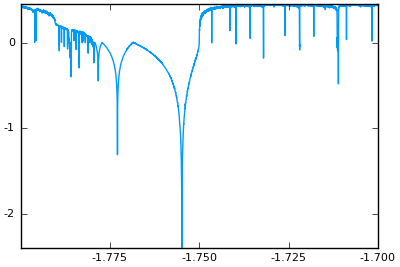

In [377]:
p = plot(c,map)

In [378]:
se3=0
ind = 0
cp3 = 0
maxmap = maxabs(map)
for i in 1:length(crange)
    if abs(map[i]) >= maxmap
        se3=crange[i]
        ind = i
    end
end
for i in ind:-1:1
    if map[i-1]/map[i+1] < 0
        cp3 = crange[i]
        break
    end
end
#map[ind-325:ind-300]
cp3

-1.7500030517578125

In [379]:
Q3c = c -> Qcⁿ(0.0, (c, 3))
se3 = newton1D(Q3c, se3)

-1.7548776662466927

In [382]:
crange = -1.74:-1/2^12:-1.8

ff = diagbifurc(Qc, 1000, 256, crange); 
cc = ones(size(ff)[1])*crange';

# Esto cambia las matrices en vectores; ayuda un poco para los dibujos
ff = reshape(ff, size(ff)[1]*size(ff)[2]);
cc = reshape(cc, size(ff));


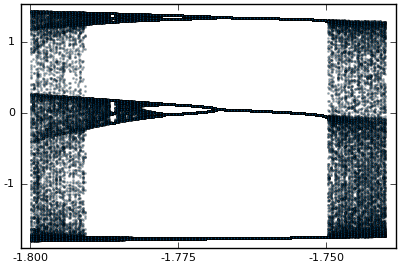

In [383]:
scatter(cc,ff, m=(1,0.3))



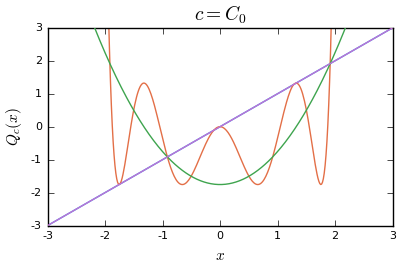

In [385]:

xrange = -3:1/64:3

plot(xrange, x->x)
plot!(xrange, x->Qcⁿ(x, (se3,3)))
plot!(xrange, x->Qcⁿ(x, (se3,1)))


plot!(xrange, x->x)
#plot!(x ->0.431683,[-3,3])
ylims!(-3,3)
xlabel!(L"x")
ylabel!(L"Q_c(x)")
title!(L"c = C_0")

In [386]:
function ciclos(c,n,xrange)
Q3c = x -> (Qcⁿ(x, (c, n))-x)
ciclo = Float64[]
    for i in xrange
        se3 = newton1D(Q3c, i)
        if abs(se3)<2
            
    push!(ciclo,se3)
        end
end
    ciclo
end


ciclos (generic function with 2 methods)


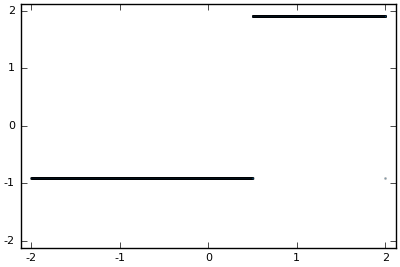

In [408]:
xrange=-2:1/2^10:2
se3_c1=ciclos(se3,1,xrange)
scatter(xrange,se3_c1,m=(1,0.3))
ylims!(-2,2)

In [436]:
function pts_estables(puntos)
    n=length(puntos)
    for j in 1:n-1
    for i in j+1:n-1
        if abs(puntos[j]-puntos[i]) < 1E-8
            puntos[i]=puntos[j]
            
        end
        end
    end
    n = length(union(puntos))
    deleteat!(sort(union(puntos)),n)
end
pts_estables(se3_c1)

2-element Array{Float64,1}:
 -0.915937
  1.91594 


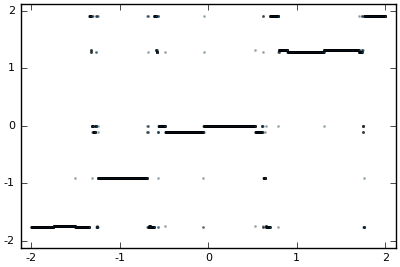

In [430]:
xrange=-2:1/2^10:2
se3_c3 = ciclos(se3,3,xrange)
scatter(xrange,se3_c3,m=(1,0.3))
ylims!(-2,2)

In [439]:
ochopts=pts_estables(se3_c3)

8-element Array{Float64,1}:
 -1.75488    
 -1.74285    
 -0.915937   
 -0.10965    
  2.22286e-16
  1.28266    
  1.32472    
  1.91594    

In [446]:
QSE31(x) = Qc(x,se3)
estable=iterado(QcSE3,ochopts[1],3)

4-element Array{Float64,1}:
 -1.75488    
  1.32472    
  2.40985e-12
 -1.75488    

In [452]:
QSE31(x) = Qc(x,se3)
inestable=(iterado(QcSE3,ochopts[2],3))

4-element Array{Float64,1}:
 -1.74285
  1.28266
 -0.10965
 -1.74285

In [453]:
QSE33 = x->Qcⁿ(x, (se3,3))
Qinestable = [QSE33(inestable[1]),QSE33(inestable[2]),QSE33(inestable[3])]

3-element Array{Float64,1}:
 -1.74285
  1.28266
 -0.10965

In [478]:
I0=[Qinestable[3],inestable[2]]

2-element Array{Float64,1}:
 -0.10965
  1.28266

In [479]:
I1=[inestable[1],inestable[3]]

2-element Array{Float64,1}:
 -1.74285
 -0.10965

In [491]:
Qc0 = Float64[]
for i in I0[1]:1/2^22:I0[2]
    qc0 = QSE31(i)
    push!(Qc0,qc0)
end
IQc0=[sort(Qc0)[1],sort(Qc0)[end]]


2-element Array{Float64,1}:
 -1.75488
 -0.10965

In [492]:
Qc1 = Float64[]
for i in I1[1]:1/2^22:I0[2]
    qc0 = QSE31(i)
    push!(Qc1,qc0)
end
IQc1=[sort(Qc1)[1],sort(Qc1)[end]]


2-element Array{Float64,1}:
 -1.75488
  1.28266